In [1]:
# from graphviper.dask.client import local_client
# viper_client = local_client(cores=4, memory_limit="4GB")

import dask

dask.config.set(scheduler="synchronous")

In [2]:
from xradio.image.image import make_empty_sky_image
import numpy as np
import xarray as xr

arcsec_to_rad = np.pi / 180 / 3600

im_xds = make_empty_sky_image(
    phase_center=[0.6, -0.2],
    image_size=[1024, 1024],
    cell_size=[arcsec_to_rad, arcsec_to_rad],
    frequency_coords=np.linspace(1.0e11, 1.1e11, 16),
    pol_coords=["I"],
    time_coords=[0],
)

im_xds

<xarray.Dataset> Size: 17MB
Dimensions:            (time: 1, frequency: 16, polarization: 1, l: 1024,
                        m: 1024, beam_params_label: 3)
Coordinates:
  * time               (time) float64 8B 0.0
  * frequency          (frequency) float64 128B 1e+11 1.007e+11 ... 1.1e+11
  * polarization       (polarization) <U1 4B 'I'
  * l                  (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                  (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    velocity           (frequency) float64 128B 1.518e+07 ... -1.328e+07
    right_ascension    (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
    declination        (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
Data variables:
    *empty*
Attributes:
    data_groups:             {'base': {}}
    coordinate_system_info:  {'reference_direction': {'attrs': {'frame': 'fk5...
    type:                    image

In [3]:
import dask.array as da

sky = da.random.random_sample(
    [1, 16, 1024, 1024, 1], chunks=[1, 2, 1024, 1024, 1]
).astype("float32")

xda = xr.DataArray(sky, dims=["time", "frequency", "l", "m", "polarization"])
im_xds["SKY"] = xda
input_data = {"img": im_xds}
im_xds

<xarray.Dataset> Size: 84MB
Dimensions:            (time: 1, frequency: 16, polarization: 1, l: 1024,
                        m: 1024, beam_params_label: 3)
Coordinates:
  * time               (time) float64 8B 0.0
  * frequency          (frequency) float64 128B 1e+11 1.007e+11 ... 1.1e+11
  * polarization       (polarization) <U1 4B 'I'
  * l                  (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                  (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    velocity           (frequency) float64 128B 1.518e+07 ... -1.328e+07
    right_ascension    (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
    declination        (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
Data variables:
    SKY                (time, frequency, l, m, polarization) float32 67MB dask.array<chunksize=(1, 2, 1024, 1024, 1), meta=np.ndarray>
Attributes:
    data_groups:             {'base': {}}
    coordinate_system_info:  {'reference_direction': {'attrs': {'frame': 'fk5...
    type:                    image

In [4]:
from xradio.image import write_image
import shutil
import os

zarr_name = "test.zarr"
if os.path.exists(zarr_name):
    shutil.rmtree(zarr_name)
write_image(im_xds, zarr_name, "zarr")

In [5]:
from graphviper.graph_tools.coordinate_utils import make_parallel_coord
from toolviper.utils.display import dict_to_html
from IPython.display import HTML, display

parallel_coords = {}
n_chunks = 4
parallel_coords["frequency"] = make_parallel_coord(
    coord=im_xds.frequency, n_chunks=n_chunks
)
display(HTML(dict_to_html(parallel_coords["frequency"])))

In [6]:
from graphviper.graph_tools.coordinate_utils import (
    interpolate_data_coords_onto_parallel_coords,
)

node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(
    parallel_coords, input_data
)
display(HTML(dict_to_html(node_task_data_mapping)))

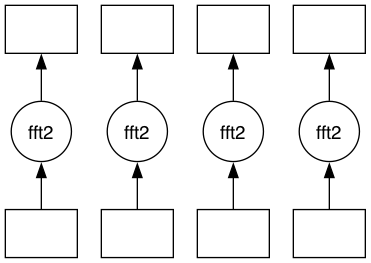

In [7]:
from graphviper.graph_tools.map import map
import dask


def _fft2(input_params):
    display(HTML(dict_to_html(input_params)))

    from xradio.image import load_image

    if input_params["input_data"] is None:  # Load
        img_xds = load_image(
            input_params["input_data_store"],
            block_des=input_params["data_selection"]["img"],
        )
    else:
        img_xds = input_params["input_data"]["img"]  # In memory

    display(img_xds)

    fft_plane = (
        img_xds["SKY"].dims.index(input_params["axes"][0]),
        img_xds["SKY"].dims.index(input_params["axes"][1]),
    )
    print("fft_plane", fft_plane)
    aperture = np.fft.fftshift(
        np.fft.fft2(np.fft.ifftshift(img_xds.SKY, axes=fft_plane), axes=fft_plane),
        axes=fft_plane,
    ).real

    img_xds["APERTURE"] = xr.DataArray(
        aperture, dims=("time", "frequency", "u", "v", "polarization")
    )

    return img_xds


input_params = {}
input_params["input_data_store"] = zarr_name
input_params["axes"] = ("l", "m")  # (3,4)

viper_graph = map(
    input_data=input_data,
    node_task_data_mapping=node_task_data_mapping,
    node_task=_fft2,
    input_params=input_params,
    in_memory_compute=False,
)
from graphviper.graph_tools import generate_dask_workflow

dask_graph = generate_dask_workflow(viper_graph)
dask.visualize(dask_graph, filename="map_graph")

In [8]:
aperture_list = dask.compute(dask_graph)

<xarray.Dataset> Size: 34MB
Dimensions:            (time: 1, frequency: 4, l: 1024, m: 1024,
                        polarization: 1, beam_params_label: 3)
Coordinates:
  * time               (time) float64 8B 0.0
  * frequency          (frequency) float64 32B 1.053e+11 1.06e+11 ... 1.073e+11
  * l                  (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                  (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * polarization       (polarization) <U1 4B 'I'
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    declination        (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
    right_ascension    (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
    velocity           (frequency) float64 32B 0.0 -1.897e+06 ... -5.692e+06
Data variables:
    SKY                (time, frequency, l, m, polarization) float32 17MB dask.array<chunksize=(1, 2, 1024, 1024, 1), meta=np.ndarray>
Attributes:
    coordinate_system_info:  {'native_pole_direction': {'attrs': {'frame': 'N...
    data_groups:             {'base': {}}
    type:                    image

fft_plane (2, 3)


<xarray.Dataset> Size: 34MB
Dimensions:            (time: 1, frequency: 4, l: 1024, m: 1024,
                        polarization: 1, beam_params_label: 3)
Coordinates:
  * time               (time) float64 8B 0.0
  * frequency          (frequency) float64 32B 1.08e+11 1.087e+11 ... 1.1e+11
  * l                  (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                  (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * polarization       (polarization) <U1 4B 'I'
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    declination        (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
    right_ascension    (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
    velocity           (frequency) float64 32B -7.59e+06 ... -1.328e+07
Data variables:
    SKY                (time, frequency, l, m, polarization) float32 17MB dask.array<chunksize=(1, 2, 1024, 1024, 1), meta=np.ndarray>
Attributes:
    coordinate_system_info:  {'native_pole_direction': {'attrs': {'frame': 'N...
    data_groups:             {'base': {}}
    type:                    image

fft_plane (2, 3)


<xarray.Dataset> Size: 34MB
Dimensions:            (time: 1, frequency: 4, l: 1024, m: 1024,
                        polarization: 1, beam_params_label: 3)
Coordinates:
  * time               (time) float64 8B 0.0
  * frequency          (frequency) float64 32B 1.027e+11 1.033e+11 ... 1.047e+11
  * l                  (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                  (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * polarization       (polarization) <U1 4B 'I'
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    declination        (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
    right_ascension    (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
    velocity           (frequency) float64 32B 7.59e+06 5.692e+06 ... 1.897e+06
Data variables:
    SKY                (time, frequency, l, m, polarization) float32 17MB dask.array<chunksize=(1, 2, 1024, 1024, 1), meta=np.ndarray>
Attributes:
    coordinate_system_info:  {'native_pole_direction': {'attrs': {'frame': 'N...
    data_groups:             {'base': {}}
    type:                    image

fft_plane (2, 3)


<xarray.Dataset> Size: 34MB
Dimensions:            (time: 1, frequency: 4, l: 1024, m: 1024,
                        polarization: 1, beam_params_label: 3)
Coordinates:
  * time               (time) float64 8B 0.0
  * frequency          (frequency) float64 32B 1e+11 1.007e+11 ... 1.02e+11
  * l                  (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                  (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * polarization       (polarization) <U1 4B 'I'
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    declination        (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
    right_ascension    (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
    velocity           (frequency) float64 32B 1.518e+07 1.328e+07 ... 9.487e+06
Data variables:
    SKY                (time, frequency, l, m, polarization) float32 17MB dask.array<chunksize=(1, 2, 1024, 1024, 1), meta=np.ndarray>
Attributes:
    coordinate_system_info:  {'native_pole_direction': {'attrs': {'frame': 'N...
    data_groups:             {'base': {}}
    type:                    image

fft_plane (2, 3)


In [9]:
len(aperture_list[0])

4

In [10]:
aperture_list[0][0]

<xarray.Dataset> Size: 50MB
Dimensions:            (time: 1, frequency: 4, l: 1024, m: 1024,
                        polarization: 1, beam_params_label: 3, u: 1024, v: 1024)
Coordinates:
  * time               (time) float64 8B 0.0
  * frequency          (frequency) float64 32B 1e+11 1.007e+11 ... 1.02e+11
  * l                  (l) float64 8kB 0.002482 0.002477 ... -0.002473 -0.002477
  * m                  (m) float64 8kB -0.002482 -0.002477 ... 0.002473 0.002477
  * polarization       (polarization) <U1 4B 'I'
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    declination        (l, m) float64 8MB -0.2025 -0.2025 ... -0.1975 -0.1975
    right_ascension    (l, m) float64 8MB 0.6025 0.6025 0.6025 ... 0.5975 0.5975
    velocity           (frequency) float64 32B 1.518e+07 1.328e+07 ... 9.487e+06
Dimensions without coordinates: u, v
Data variables:
    SKY                (time, frequency, l, m, polarization) float32 17MB dask.array<chunksize=(1, 2, 1024, 1024, 1), meta=np.ndarray>
    APERTURE           (time, frequency, u, v, polarization) float32 17MB -63...
Attributes:
    coordinate_system_info:  {'native_pole_direction': {'attrs': {'frame': 'N...
    data_groups:             {'base': {}}
    type:                    image

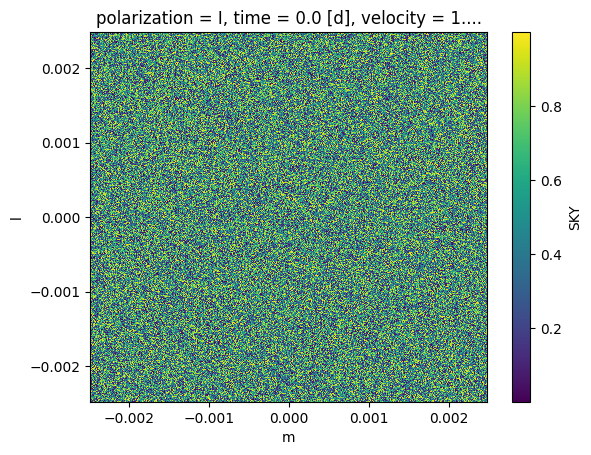

In [11]:
aperture_list[0][0]["SKY"].sel(polarization="I").isel(frequency=2, time=0).plot()

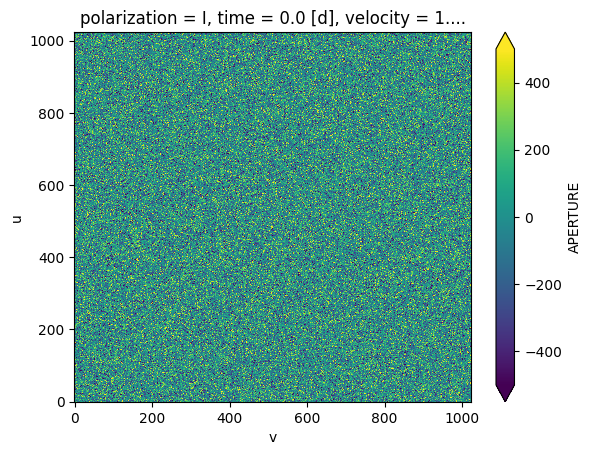

In [12]:
aperture_list[0][0]["APERTURE"].sel(polarization="I").isel(frequency=2, time=0).plot(
    vmin=-500, vmax=500
)